# Data Science Assessment - Fraud Data (Hyunjun Lee)

## 0. Prerequisites

- import required dependencies to analyze and fit machine-learning classifiers

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import mannwhitneyu, chi2_contingency

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

## 1. Data Engineering

- load data files via Pandas package into a DataFrame format

In [2]:
df_train = pd.read_csv('Candidate_tech_evaluation_candidate_copy_data science_fraud.csv')
df_test = pd.read_csv('fraud_holdout_no_label.csv')
df_ip = pd.read_excel('Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx')

- define function to map country names with respect to the aligned IP address range
- apply the function to map country names and store it into 'country' variable
- for missing values, fill them with 'ETC' values

In [4]:
def ip_to_country_mapping(ip):
    """Maps IP address to country using the ip_to_country DataFrame."""
    country = df_ip[(df_ip['lower_bound_ip_address'] <= ip) &
                    (df_ip['upper_bound_ip_address'] >= ip)]['country']
    if country.shape[0] == 1:
        return country.iloc[0]
    else:
        return None

df_train['country'] = df_train['ip_address'].apply(ip_to_country_mapping)
df_test['country'] = df_test['ip_address'].apply(ip_to_country_mapping)
df_train.loc[df_train['country'].isna(), 'country'] = 'ETC'
df_test.loc[df_test['country'].isna(), 'country'] = 'ETC'

- save and load modified DataFrames to perform EDA

In [5]:
df_train[list(df_train.columns)[1:]].to_csv('df_train.csv', index=False)
df_test[list(df_test.columns)[1:]].to_csv('df_test.csv', index=False)

In [6]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [7]:
df_train.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States


In [8]:
df_test.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,country
0,159135,2015-05-21 6:03,2015-07-09 8:05,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,Canada
1,50116,2015-08-01 22:40,2015-08-27 3:37,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,ETC
2,182338,2015-01-25 17:49,2015-03-23 23:05,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,United States


## 2. Exploratory Data Analysis (EDA)

- create new variables to explore:
    - `latency`: duration to process the first transaction
    - `num_transaction_per_device`: the number of transactions for each device IDs

In [9]:
df_train['signup_time'] = pd.to_datetime(df_train['signup_time'])
df_train['purchase_time'] = pd.to_datetime(df_train['purchase_time'])
df_train['latency'] = (df_train['purchase_time'] - df_train['signup_time']).dt.total_seconds() / 3600
df_train['num_transaction_per_device'] = df_train.groupby('device_id')['device_id'].transform('count')

df_test['signup_time'] = pd.to_datetime(df_test['signup_time'])
df_test['purchase_time'] = pd.to_datetime(df_test['purchase_time'])
df_test['latency'] = (df_test['purchase_time'] - df_test['signup_time']).dt.total_seconds() / 3600
df_test['num_transaction_per_device'] = df_test.groupby('device_id')['device_id'].transform('count')

- Examining the numerical features, variables `latency` and `num_transaction_per_device` have strong relationship with `class` variable

    - lower `latency` (mostly 0) implies the possibility of fraudulent transactions
    - higher `num_transactions_per_device` implies the possibility of fraudulent transactions


- arguments above would be supported by the statistical testing under the significance level 0.05 (*Mann-Whitney U test to compare empirical distribution*)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



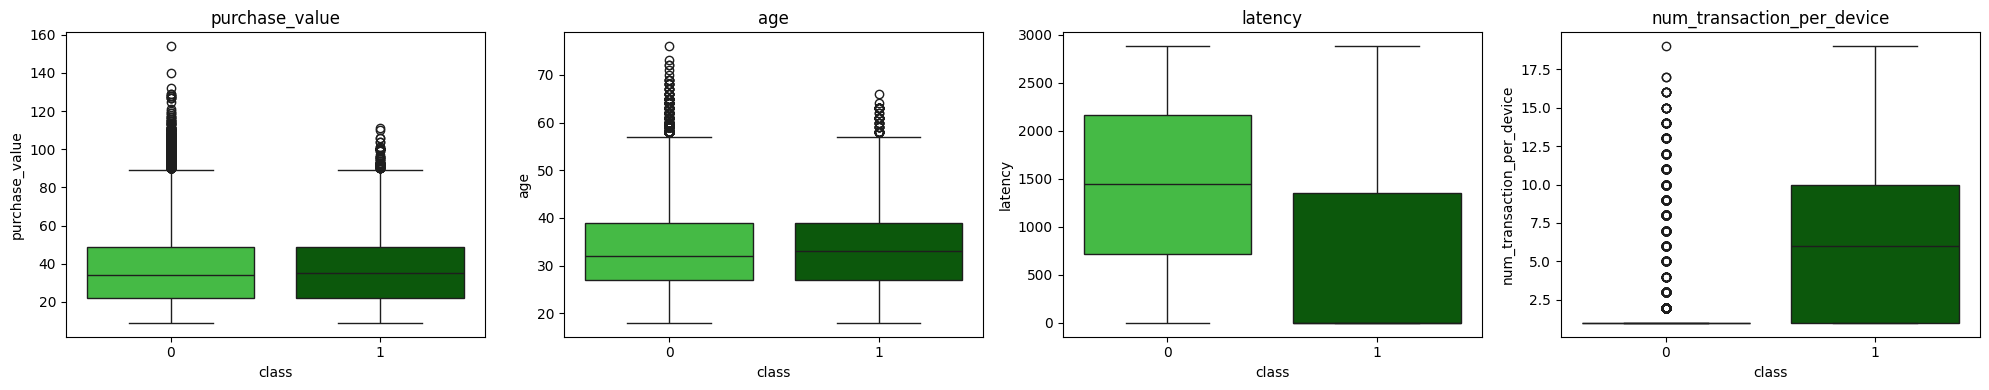

In [10]:
target_independent_vars = ['purchase_value', 'age', 'latency', 'num_transaction_per_device']
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for idx in range(4):
    sns.boxplot(x='class', y=target_independent_vars[idx], data=df_train, ax=axes[idx],
                palette={'0': 'limegreen', '1': 'darkgreen'})
    axes[idx].set_title('{}'.format(target_independent_vars[idx]))
plt.tight_layout()
plt.show()

In [11]:
p_values = {}
for var in target_independent_vars:
    g0 = df_train[df_train['class'] == 0][var]
    g1 = df_train[df_train['class'] == 1][var]
    _, pval = mannwhitneyu(g0, g1, alternative='two-sided')
    p_values[var] = pval

print(p_values)

{'purchase_value': 0.2678986456159931, 'age': 0.02554848184551772, 'latency': 0.0, 'num_transaction_per_device': 0.0}


- Examining the categorical features via statistical testing (*Chi-squared test*), that can be said that there would be differences in mean level of proportions in `class` variable among categories, which have to be verified with machine-learning modeling

In [12]:
target_independent_vars_cat = ['source', 'browser', 'sex', 'country']
p_values_cat = {}
for var in target_independent_vars_cat:
    contingency = pd.crosstab(df_train[var], df_train['class'])
    _, pval, _, _ = chi2_contingency(contingency)
    p_values_cat[var] = pval

print(p_values_cat)

{'source': 1.2766489281183212e-11, 'browser': 5.096579084066713e-08, 'sex': 0.027977635034273925, 'country': 2.2975934051246595e-64}


## 3. Model Selection Procedure

- Candidate classifiers are:
    - RandomForest classifier
    - Support Vector Machine
    - Histogram-based Gradient Boosting

- Feature transformations has been applied:
    - for numerical features: standardization
    - for categorical features: ordinal encoding

- for each machine-learning models, hyperparameter search space have been set and performed via 5-fold cross validation

- evaluation metric for cross-validation is ROC-AUC score

- Note that cross-validation had been performed on backend process rather than to exploit notebook script

In [13]:
label = 'class'
features_num = ['purchase_value', 'age', 'latency', 'num_transaction_per_device']
features_cat = ['source', 'browser', 'sex', 'country']

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OrdinalEncoder(), features_cat)
    ])

X = df_train.drop(columns=['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class'])
y = df_train['class']

X_transformed = preprocessor.fit_transform(X)
print(X_transformed.shape)

(120000, 8)


In [15]:
cv = StratifiedKFold(n_splits=5)

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 5, 10, 15, 20, 25],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__degree': [2, 3, 4]  # Only relevant for 'poly' kernel
    },
    'HistGradientBoosting': {
        'classifier__learning_rate': [0.001, 0.01, 0.1, 1],
        'classifier__max_iter': [50, 100, 150],
        'classifier__max_depth': [None, 5, 10, 15, 20],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
}


classifiers = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'HistGradientBoosting': HistGradientBoostingClassifier()
}

In [ ]:
results = {}

for name, classifier in classifiers.items():
    pipeline = ImbPipeline([
        ('under_sampler', RandomUnderSampler()),
        ('classifier', classifier)
    ])
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
    grid_search.fit(X_transformed, y)
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

with open('results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

- Examining the results, all 3 models performed similarly
- Thus, choose `HistGradientBoosting` classifier as our final model, considering computational efficiency

In [16]:
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

In [17]:
results

{'RandomForest': {'best_params': {'classifier__class_weight': None,
   'classifier__max_depth': 25,
   'classifier__min_samples_leaf': 2,
   'classifier__min_samples_split': 10,
   'classifier__n_estimators': 200},
  'best_score': 0.8309444031859667},
 'SVM': {'best_params': {'classifier__C': 0.01,
   'classifier__class_weight': 'balanced',
   'classifier__degree': 2,
   'classifier__kernel': 'linear'},
  'best_score': 0.8291919434796207},
 'HistGradientBoosting': {'best_params': {'classifier__learning_rate': 0.1,
   'classifier__max_depth': None,
   'classifier__max_iter': 50,
   'classifier__min_samples_leaf': 4},
  'best_score': 0.8311551183850939}}

In [18]:
final_model = HistGradientBoostingClassifier(learning_rate=0.1,
                                             max_depth=None,
                                             max_iter=50,
                                             min_samples_leaf=4)

In [19]:
indices = np.arange(X_transformed.shape[0])
indices_train, indices_val = train_test_split(
    indices, test_size=0.2, random_state=42
)

In [20]:
X_train = X_transformed[indices_train]
X_val = X_transformed[indices_val]
y_train = y[indices_train]
y_val = y[indices_val]

In [21]:
clf = final_model.fit(X_train, y_train)

In [22]:
print("validation scores")
y_val_pred = clf.predict(X_val)
cm = pd.DataFrame(
    confusion_matrix(y_val, y_val_pred),
    index=['True:Normal', 'True:Fraud'],
    columns=['Pred:Normal', 'Pred:Fraud']
)
print(cm)

validation scores
             Pred:Normal  Pred:Fraud
True:Normal        21757          11
True:Fraud          1049        1183


In [23]:
valid_worth = df_train.iloc[indices_val][(y_val == 1) & (y_val_pred == 1)]['purchase_value'].sum()
print("Fraud detection worth: USD {}".format(valid_worth))
print("Missing worth:         USD {}".format(80))

Fraud detection worth: USD 42830
Missing worth:         USD 80


- Analyzing the results for validation dataset:
    - 1,183 fraud cases had been detected among 2,232 cases (worth USD 42,830)
    - 11 missing cases had been occred for normal transactions (worth USD 88)
- Aggregating those, proposed machine-learning method **worth USD 42,742**

## 4. Feature importance analysis via SHAP(SHapley Additive exPlanations)

- Looking into the approximated shapley values assessed via TreeSHAP method, `latency` and `num_transactions_per_device` are dominantly determines fraudulent transactions

In [24]:
explainer = shap.TreeExplainer(clf)

In [25]:
shap_values = explainer.shap_values(X_train)

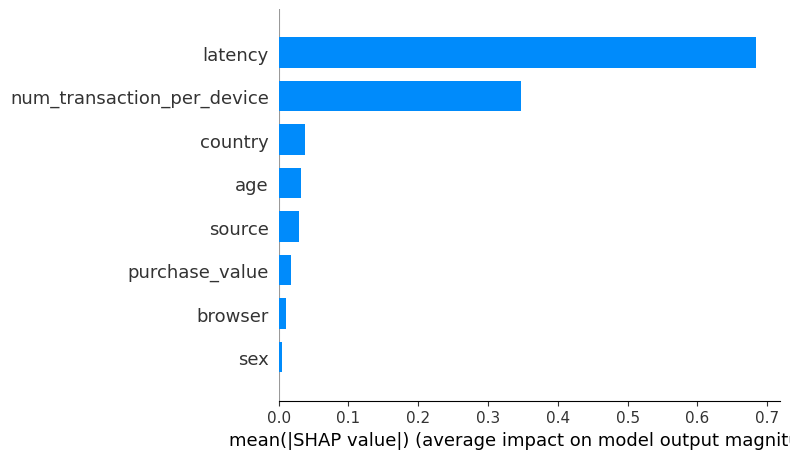

In [28]:
shap.summary_plot(shap_values, X_train, plot_type='bar',
                  feature_names = features_num + features_cat)

## 5. Test data assessment

In [29]:
X_test = df_test.drop(columns=['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])

X_test = preprocessor.fit_transform(X_test)
print(X_test.shape)

(31112, 8)


In [30]:
y_test_pred = clf.predict(X_test)

In [32]:
df_test_raw = pd.read_csv('fraud_holdout_no_label.csv')
df_test_raw['class'] = y_test_pred

In [34]:
df_test_raw.to_csv("datascience_assessment_submission.csv", index=False)